# Replication of attack on VoIP end-to-end encrypted messengers

## Loading dataset

First we will try to load our data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

sns.set()  # make plots nicer

np.random.seed(42)  # set seed for reproducibility

Format of the input file is as follows (with examples of data, that can be there):  
**Line indicating spoken phrase:** _Sentence: "She had your dark suit in greasy wash water all year."_  
**Line with information about current transmission** _Packets: 146, Samples: 46797, Samples per packet: 320_  
**Line with data**: _74;ix,hv;"she","had"_ (packet size, phonemes, words)

In [2]:
# data format: name (of csv file); sentence; (packet size, [phonems], [words])
def file_parser(path):
    file = open(path, 'r')
    lines = file.readlines()
    
    file_name = [path.split('/')[-1]]
    sentence = ""
    file_data = []
    
    for line in lines:
        line = line.strip()
        
        # if there are only 2 informations on line and second is h#, then ignore
        # strip line, split primarly on ; secondary on ,
        if (line.startswith('#')):
            if (not sentence):
                sentence = line[len('# Sentence: "'): len(line) - 1]
            continue
        
        line = line.split(';')
        
        if (len(line) == 1):
            #lines containing only their packet size and nothing else, they should be added
            line += [""]
            line += [""]
        
        if (len(line) == 2):
            #this tries to remove most of the silence at the start of the recording
            #if (line[1] == 'h#'):
            #    continue
            line += [""]
        
        line[1] = tuple(line[1].split(','))
        line[2] = tuple(list(map(lambda a: a.strip('"'), line[2].split(','))))
           
        # file_name and author contain duplicate informations, but are kept for readability
        line = file_name + [file_name[0][0:9]] + [sentence] + line
        file_data += [line]

    return pd.DataFrame(file_data, columns=['file', 'speaker', 'sentence', 'packet_size', 'phonemes', 'words'])

def load_files(directory):
    filelist = os.listdir(directory)
    #read them into pandas
    df_list = [file_parser(directory+file) for file in filelist]
    #concatenate them together
    return pd.concat(df_list, ignore_index=True)

In [3]:
#file_parser("./../data/whatsapp_train_data/DR1-FSAH0-SI614.CSV")   

data = load_files("./../data/whatsapp_train_data/")
data

,file,speaker,sentence,packet_size,phonemes,words
0,DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,227,"(h#,)","(,)"
1,DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,380,"(h#, sh, ix)","(she,)"
2,DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,407,"(ix, hv, eh)","(she, had)"
3,DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,350,"(eh, dcl, jh)","(had, your)"
4,DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,281,"(jh, ih, dcl, d, ah)","(had, your, dark)"
...,...,...,...,...,...,...
86492,DR8-MTCS0-SX82.CSV,DR8-MTCS0,Good service should be rewarded by big tips.,268,"(ay, bcl, b, ih)","(by, big)"
86493,DR8-MTCS0-SX82.CSV,DR8-MTCS0,Good service should be rewarded by big tips.,253,"(ih, gcl)","(big,)"
86494,DR8-MTCS0-SX82.CSV,DR8-MTCS0,Good service should be rewarded by big tips.,315,"(gcl, t, ih)","(big, tips)"
86495,DR8-MTCS0-SX82.CSV,DR8-MTCS0,Good service should be rewarded by big tips.,279,"(ih, pcl, p)","(tips,)"


For our purposes we've decided to omit beggings and ends of the files as they contain only some silence. Maybe it would be worth investigating what the accuracy would be, had we not remowed these.

Let's convert the `packet_size` from _object_ to _numerical value_ and `file`, `sentence` to the type _category_.

In [4]:
data['packet_size'] = pd.to_numeric(data['packet_size'])

In [5]:
data['file'] = data['file'].astype('category')
data['sentence'] = data['sentence'].astype('category')
#data['speaker'] = data['speaker'].astype('category')

In [6]:
data.dtypes

file           category
speaker          object
sentence       category
packet_size       int64
phonemes         object
words            object
dtype: object

## Exploratory analysis

For most of our exploratory analysis we will use the powerfull tool of `pandas_profilling` which can provide us with many interesting graphs and statistics, which we can use.

Our first step in exploratory analysis will be to just to look at data without modifying anything (expect the column types)

In [7]:
import pandas_profiling as pp
from pandas_profiling import ProfileReport

ProfileReport(data, "First look at data")

From this analysis we can see, that we have 4620 distinct files (which isn't surprising, we already knew that), 462 distinct speakers and 1737 unique sentences. Sadly `pandas_profilling` doesn't seem to be up to this task as converting phonemes and words to cathegorical values breaks `pandas_profilling`. This is caused by current implementation of `pandas` that requires categorical list like objects to be of the same length so it can do the comparison (_categorical.py in func(self, other), lines 70 to 72_).

Now we will get the frequencies of senteces.

In [8]:
frequencies = data[['sentence', 'file']].drop_duplicates(subset=['file'])['sentence'].value_counts()
frequencies

She had your dark suit in greasy wash water all year.                         462
Don't ask me to carry an oily rag like that.                                  461
Growing well-kept gardens is very time consuming.                               7
Correct execution of my instructions is crucial.                                7
Cyclical programs will never compile.                                           7
                                                                             ... 
Sprouted grains and seeds are used in salads and dishes such as chop suey.      1
State numbering laws differ from each other in many ways.                       1
Stay right here where you are, kid, he called.                                  1
Stoneware clay for tiles.                                                       1
"Cable confirmation", it said translated.                                       1
Name: sentence, Length: 1737, dtype: int64

In [9]:
np.asarray(np.unique(frequencies.array.to_numpy(), return_counts=True)).T

array([[   1, 1402],
       [   2,    3],
       [   4,    1],
       [   5,    2],
       [   6,   14],
       [   7,  313],
       [ 461,    1],
       [ 462,    1]], dtype=int64)

We can see, that the sentence column is heavily skewed as 30% of our dataset is composed of sentences, which are spoken only once. 10% takes the sentence _She had your dark suit in greasy wash water all year._ and another 10% takes sentence _Don't ask me to carry an oily rag like that._ The remaining 50% of the data are sentences, that have more than one occurance, but not by a high margin.

Now we can properly convert words and phonemes to their proper type -> category

In [10]:
# this conversion breaks pandas_profiling :(
# actually I know why this breaks profilling, pandas requieres categorical list like structures to be of the same length for reasons unknown
data['phonemes'] = data['phonemes'].astype('category')
data['words'] = data['words'].astype('category')

### Statistic for packet sizes for specific phonemes / words

Now let's look at packet sizes for few select words / phonemes. From the first look at data I would say, that packet sizes for phonemes will be more important for the `skype` dataset and packet sizes for words will be more important for `whatsapp` dataset.<br />
This is because `skype` dataset uses much smaller packet sizes, therefore it is highly probable, that only one phoneme will correspond to only one packet size and the same goes for `whatsapp` dataset, that has much bigger packets and from my observation one packet corresponds to one word.

In [11]:
label_data = data.loc[:, ('packet_size', 'phonemes', 'words', 'sentence')]
label_data

,packet_size,phonemes,words,sentence
0,227,"(h#,)","(,)",She had your dark suit in greasy wash water al...
1,380,"(h#, sh, ix)","(she,)",She had your dark suit in greasy wash water al...
2,407,"(ix, hv, eh)","(she, had)",She had your dark suit in greasy wash water al...
3,350,"(eh, dcl, jh)","(had, your)",She had your dark suit in greasy wash water al...
4,281,"(jh, ih, dcl, d, ah)","(had, your, dark)",She had your dark suit in greasy wash water al...
...,...,...,...,...
86492,268,"(ay, bcl, b, ih)","(by, big)",Good service should be rewarded by big tips.
86493,253,"(ih, gcl)","(big,)",Good service should be rewarded by big tips.
86494,315,"(gcl, t, ih)","(big, tips)",Good service should be rewarded by big tips.
86495,279,"(ih, pcl, p)","(tips,)",Good service should be rewarded by big tips.


In [12]:
len(pd.unique(label_data['phonemes']))

27369

In [13]:
len(pd.unique(label_data['words']))

16168

From this we can see, that we have 27369 (for skype it was 3083) unique n-grams of phonemes and (for skype it was 15713) 16168 unique n-grams of words.

#### Phonemes

Now we will look at the top most occuring phonemes and define analysis for specific phonemes / words:

In [14]:
label_frequencies = label_data['phonemes'].value_counts()
label_frequencies.head(20)

(h#,)           3953
(s, h#)          486
(h#, sh)         467
(h#, dh)         380
(pau,)           340
(axr, h#)        333
(s, ux)          321
(ae,)            319
(h#, d, ow)      317
(z, h#)          306
(ae, s)          285
(r, ae)          285
(sh, iy)         276
(ae, tcl)        238
(ao, l, y)       237
(h#, hh)         234
(ay,)            232
(h#, q)          219
(h#, w)          197
(iy, hv, ae)     176
Name: phonemes, dtype: int64

In [15]:
from IPython.display import display

def get_distribution_info(dataframe, xlabel):
    Q1 = dataframe.packet_size.quantile(0.25)
    Q3 = dataframe.packet_size.quantile(0.75)
    IQR = Q3 - Q1

    print("Current label:\t\t", xlabel)
    print("Total values:", dataframe.packet_size.count())
    print("Lower outsiders:", (dataframe.packet_size < (Q1 - 1.5 * IQR)).sum())
    print("Upper outsiders:", (dataframe.packet_size > (Q3 + 1.5 * IQR)).sum())
    print()
    
    plt.figure()
    dataframe.packet_size.plot.box()
    plt.xlabel(xlabel)
    plt.show()
    plt.figure()
    dataframe.packet_size.plot.hist()
    plt.show()

    #display(dataframe[dataframe.packet_size < (Q1 - 1.5 * IQR)].sort_values('packet_size').head(10))
    #display(dataframe[dataframe.packet_size > (Q3 + 1.5 * IQR)].sort_values('packet_size', ascending=False).head(10))
    
    display(dataframe.sort_values('packet_size').head(10))
    display(dataframe.sort_values('packet_size', ascending=False).head(10))

We will take a look at a few of the most common phonemes (and the most common pair of phonemes) and see whether they are evenly distributed or not at all:

Unique packet values: 204 	Unique words: 1
Current label:		 ('h#',)
Total values: 3953
Lower outsiders: 0
Upper outsiders: 2



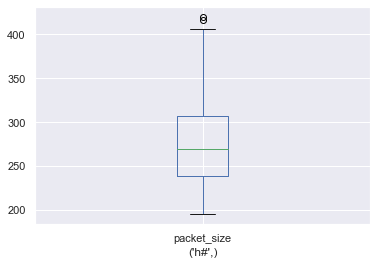

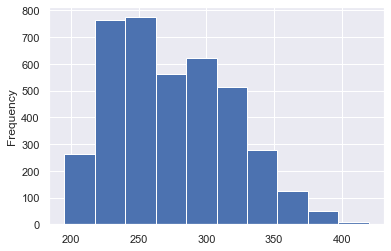

,packet_size,phonemes,words,sentence
45465,195,"(h#,)","(,)",Don't forget whiskey; it's such a big seller.
77541,196,"(h#,)","(,)",Drug's chemical name: procaine penicillin.
74673,197,"(h#,)","(,)",Don't ask me to carry an oily rag like that.
77454,197,"(h#,)","(,)",She had your dark suit in greasy wash water al...
21466,197,"(h#,)","(,)",Her auburn hair reminded him of autumn leaves.
15407,198,"(h#,)","(,)",I just saw Jim near the new archeological museum.
9169,198,"(h#,)","(,)",She can remove all knick-knacks within reach.
34678,198,"(h#,)","(,)",You need answers to four important questions.
21528,198,"(h#,)","(,)","Coffee is grown on steep, jungle-like slopes i..."
25326,199,"(h#,)","(,)",Don't ask me to carry an oily rag like that.


,packet_size,phonemes,words,sentence
23944,420,"(h#,)","(,)",Continental drift is a geological theory.
2501,416,"(h#,)","(,)",No manufacturer has taken the initiative in po...
4622,406,"(h#,)","(,)",The eastern coast is a place for pure pleasure...
18542,401,"(h#,)","(,)",How would you evaluate this algebraic expression?
69929,399,"(h#,)","(,)","A thick, crimson carpet muffled every footfall."
51381,399,"(h#,)","(,)",Under this law annual grants are given to syst...
40904,398,"(h#,)","(,)","He spoke briefly, sensibly, to the point and w..."
7832,398,"(h#,)","(,)",You do that or take you out a permit right now.
53520,394,"(h#,)","(,)",Absolution for his lie?
67760,394,"(h#,)","(,)",Too much curiosity can get you into trouble.




Unique packet values: 145 	Unique words: 216
Current label:		 ('s', 'h#')
Total values: 486
Lower outsiders: 0
Upper outsiders: 0



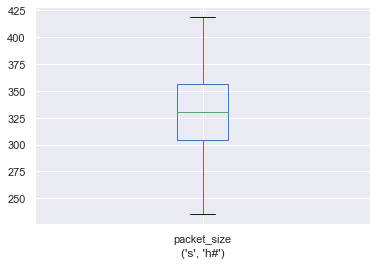

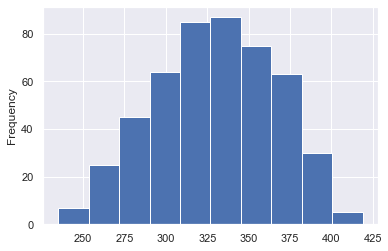

,packet_size,phonemes,words,sentence
55766,235,"(s, h#)","(ruins,)",The Mayan neoclassic scholar disappeared while...
23892,237,"(s, h#)","(tests,)",Scholastic aptitude is judged by standardized ...
39424,237,"(s, h#)","(us,)",We have also seen the power of faith at work a...
53908,241,"(s, h#)","(flurries,)",We could barely see the fjords through the sno...
3751,244,"(s, h#)","(inferences,)","But briefly, the topping configuration must be..."
45803,249,"(s, h#)","(box,)",Gently place Jim's foam sculpture in the box.
15576,251,"(s, h#)","(skills,)",Addition and subtraction are learned skills.
2183,257,"(s, h#)","(backgrounds,)","Differences were related to social, economic, ..."
17830,257,"(s, h#)","(fireplace,)","In the winter, hibachi in the kitchen or grill..."
65100,258,"(s, h#)","(innocence,)",Nothing is as offensive as innocence.


,packet_size,phonemes,words,sentence
46608,419,"(s, h#)","(axis,)",Draw each graph on a new axis.
52444,407,"(s, h#)","(ices,)",The paper boy bought two apples and three ices.
62440,404,"(s, h#)","(yards,)",Cement is measured in cubic yards.
68022,403,"(s, h#)","(process,)",Shipbuilding is a most fascinating process.
43282,401,"(s, h#)","(steps,)",Eat your raisins outdoors on the porch steps.
71045,396,"(s, h#)","(querulous,)","He looked lazy, spoiled, a little querulous."
32475,395,"(s, h#)","(steps,)",Eat your raisins outdoors on the porch steps.
49566,395,"(s, h#)","(muscles,)",The jaw operates by using antagonistic muscles.
19188,394,"(s, h#)","(zebras,)",Iris thinks this zoo has eleven Spanish zebras.
56249,394,"(s, h#)","(coals,)",Also make sure thermometer does not touch the ...




Unique packet values: 138 	Unique words: 3
Current label:		 ('pau',)
Total values: 340
Lower outsiders: 0
Upper outsiders: 0



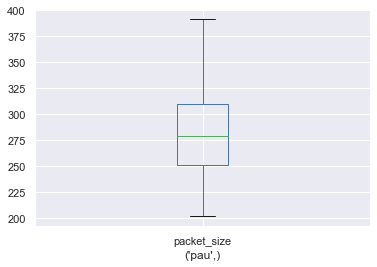

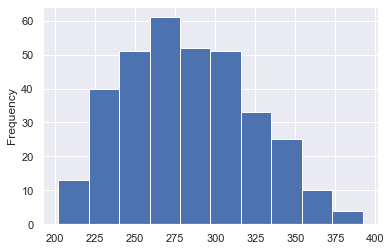

,packet_size,phonemes,words,sentence
35437,202,"(pau,)","(,)",Push back up and repeat.
84665,208,"(pau,)","(,)",Ducks have webbed feet and colorful feathers.
10642,209,"(pau,)","(,)","Ants carry the seeds, so better be sure that t..."
21971,214,"(pau,)","(,)",Look for these features which may mean you can...
86010,214,"(pau,)","(,)","To begin with, what is an interior designer?"
25199,215,"(pau,)","(,)","Two cars came over a crest, their chrome and g..."
63320,215,"(pau,)","(,)","Wingman, stay clear, he prayed."
59053,216,"(pau,)","(,)","Though brief, it has a sharp dramatic edge and..."
56402,216,"(pau,)","(,)","Push-ups: push-ups are essential, but few have..."
35187,219,"(pau,)","(,)",Several factors contributed to this change.


,packet_size,phonemes,words,sentence
54461,392,"(pau,)","(autofluorescence,)",This was chiefly because of the bluish white a...
54526,384,"(pau,)","(,)",Employee layoffs coincided with the company's ...
36543,382,"(pau,)","(,)","His eyes were dark, fluid, fearful, and he gav..."
50327,377,"(pau,)","(,)","The smell is sexual, but so powerfully so that..."
54768,372,"(pau,)","(,)",Flying standby can be practical if you want to...
82745,370,"(pau,)","(,)","According to my interpretation of the problem,..."
40913,368,"(pau,)","(,)","He spoke briefly, sensibly, to the point and w..."
36544,362,"(pau,)","(,)","His eyes were dark, fluid, fearful, and he gav..."
58056,360,"(pau,)","(,)",Chocolate and roses never fail as a romantic g...
49512,360,"(pau,)","(,)","A kerosene shampoo seems a heroic treatment, b..."




Unique packet values: 98 	Unique words: 1
Current label:		 ('ao', 'l', 'y')
Total values: 237
Lower outsiders: 1
Upper outsiders: 0



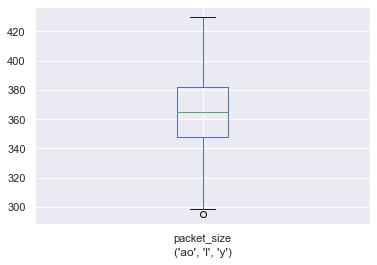

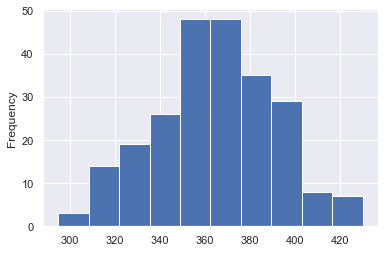

,packet_size,phonemes,words,sentence
35360,295,"(ao, l, y)","(all, year)",She had your dark suit in greasy wash water al...
43707,299,"(ao, l, y)","(all, year)",She had your dark suit in greasy wash water al...
46663,304,"(ao, l, y)","(all, year)",She had your dark suit in greasy wash water al...
78012,311,"(ao, l, y)","(all, year)",She had your dark suit in greasy wash water al...
43951,311,"(ao, l, y)","(all, year)",She had your dark suit in greasy wash water al...
35154,311,"(ao, l, y)","(all, year)",She had your dark suit in greasy wash water al...
73914,312,"(ao, l, y)","(all, year)",She had your dark suit in greasy wash water al...
59242,314,"(ao, l, y)","(all, year)",She had your dark suit in greasy wash water al...
10974,315,"(ao, l, y)","(all, year)",She had your dark suit in greasy wash water al...
84902,316,"(ao, l, y)","(all, year)",She had your dark suit in greasy wash water al...


,packet_size,phonemes,words,sentence
65487,430,"(ao, l, y)","(all, year)",She had your dark suit in greasy wash water al...
19574,425,"(ao, l, y)","(all, year)",She had your dark suit in greasy wash water al...
85073,424,"(ao, l, y)","(all, year)",She had your dark suit in greasy wash water al...
44525,420,"(ao, l, y)","(all, year)",She had your dark suit in greasy wash water al...
31544,420,"(ao, l, y)","(all, year)",She had your dark suit in greasy wash water al...
67478,419,"(ao, l, y)","(all, year)",She had your dark suit in greasy wash water al...
29703,417,"(ao, l, y)","(all, year)",She had your dark suit in greasy wash water al...
86120,415,"(ao, l, y)","(all, year)",She had your dark suit in greasy wash water al...
64490,415,"(ao, l, y)","(all, year)",She had your dark suit in greasy wash water al...
72328,413,"(ao, l, y)","(all, year)",She had your dark suit in greasy wash water al...


In [16]:
label_data['phonemes'] = label_data['phonemes'].astype('object')

#change this array for analysis on more values
interesting_phonemes = [("h#",), ("s","h#"), ("pau",), ("ao", "l", "y")]

for phoneme in interesting_phonemes:
    graph_data = label_data.loc[label_data.phonemes == phoneme]
    print("Unique packet values:", len(pd.unique(graph_data['packet_size'])), "\tUnique words:", len(pd.unique(graph_data['words'])))
    get_distribution_info(graph_data, phoneme)
    print('\n')

label_data['phonemes'] = label_data['phonemes'].astype('category')

From these graphs we can already see a few alarming things. First of all the phonemes sizes are all over the place suggesting, that there shouldn't be much a a correlation between packet size and spoken phonemes. We will try to make further observations taking into account the surrounding phonemes as that should prove more fruitfull than only focusing on phonemes alone.

#### Words

In [17]:
label_frequencies = label_data['words'].value_counts()
label_frequencies.head(20)

(,)             4358
(that,)          976
(year,)          887
(she,)           820
(wash,)          670
(greasy,)        667
(don't,)         643
(water,)         636
(carry,)         611
(suit,)          567
(the,)           535
(rag,)           528
(oily,)          518
(dark,)          488
(dark, suit)     468
(like, that)     464
(oily, rag)      462
(don't, ask)     461
(she, had)       459
(rag, like)      458
Name: words, dtype: int64

Unique values: 206 	Unique phonemes: 12
Current label:		 ('',)
Total values: 4358
Lower outsiders: 0
Upper outsiders: 2



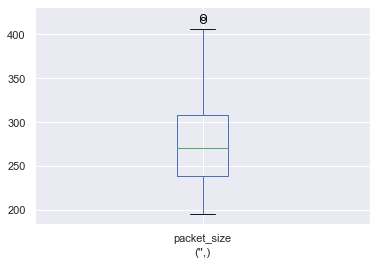

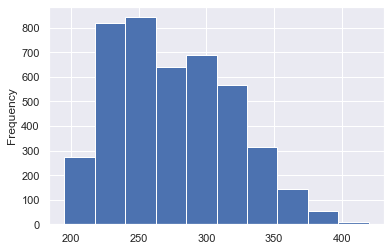

,packet_size,phonemes,words,sentence
45465,195,"(h#,)","(,)",Don't forget whiskey; it's such a big seller.
77541,196,"(h#,)","(,)",Drug's chemical name: procaine penicillin.
77454,197,"(h#,)","(,)",She had your dark suit in greasy wash water al...
21466,197,"(h#,)","(,)",Her auburn hair reminded him of autumn leaves.
74673,197,"(h#,)","(,)",Don't ask me to carry an oily rag like that.
9169,198,"(h#,)","(,)",She can remove all knick-knacks within reach.
21528,198,"(h#,)","(,)","Coffee is grown on steep, jungle-like slopes i..."
15407,198,"(h#,)","(,)",I just saw Jim near the new archeological museum.
34678,198,"(h#,)","(,)",You need answers to four important questions.
43569,199,"(h#,)","(,)",The tragic stage is a platform extending preca...


,packet_size,phonemes,words,sentence
23944,420,"(h#,)","(,)",Continental drift is a geological theory.
2501,416,"(h#,)","(,)",No manufacturer has taken the initiative in po...
4622,406,"(h#,)","(,)",The eastern coast is a place for pure pleasure...
18542,401,"(h#,)","(,)",How would you evaluate this algebraic expression?
7250,400,"(,)","(,)",Both have excellent integration of their fisca...
51381,399,"(h#,)","(,)",Under this law annual grants are given to syst...
69929,399,"(h#,)","(,)","A thick, crimson carpet muffled every footfall."
7832,398,"(h#,)","(,)",You do that or take you out a permit right now.
40904,398,"(h#,)","(,)","He spoke briefly, sensibly, to the point and w..."
43307,395,"(,)","(,)",Don't ask me to carry an oily rag like that.




Unique values: 192 	Unique phonemes: 51
Current label:		 ('that',)
Total values: 976
Lower outsiders: 0
Upper outsiders: 1



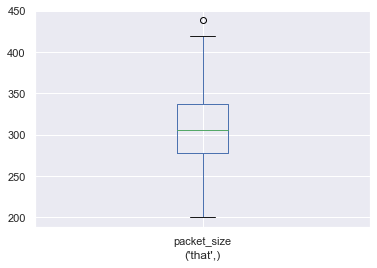

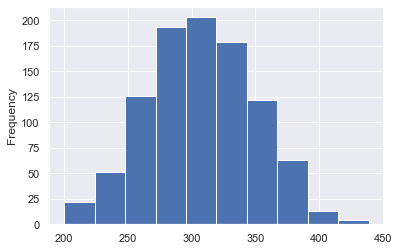

,packet_size,phonemes,words,sentence
30259,200,"(tcl, h#)","(that,)",Don't ask me to carry an oily rag like that.
63094,208,"(tcl,)","(that,)",Don't ask me to carry an oily rag like that.
5154,209,"(tcl, h#)","(that,)",Don't ask me to carry an oily rag like that.
2797,209,"(ae, tcl, h#)","(that,)",Don't ask me to carry an oily rag like that.
60650,210,"(tcl, h#)","(that,)",Don't ask me to carry an oily rag like that.
24397,210,"(q, h#)","(that,)",Don't ask me to carry an oily rag like that.
46444,210,"(tcl,)","(that,)",That pickpocket was caught red-handed.
39160,213,"(tcl, h#)","(that,)",Don't ask me to carry an oily rag like that.
3490,214,"(tcl, h#)","(that,)",Don't ask me to carry an oily rag like that.
45280,215,"(tcl, h#)","(that,)",Don't ask me to carry an oily rag like that.


,packet_size,phonemes,words,sentence
40283,439,"(ae,)","(that,)",Don't ask me to carry an oily rag like that.
28507,419,"(ae,)","(that,)",Don't ask me to carry an oily rag like that.
83348,418,"(ae,)","(that,)",Don't ask me to carry an oily rag like that.
74123,416,"(ae,)","(that,)",Don't ask me to carry an oily rag like that.
3691,413,"(ae,)","(that,)",Don't ask me to carry an oily rag like that.
45634,411,"(ae,)","(that,)",Don't ask me to carry an oily rag like that.
71236,410,"(dh, ae)","(that,)",Don't ask me to carry an oily rag like that.
22212,407,"(dh, ae, tcl)","(that,)",That dog chases cats mercilessly.
13748,405,"(dh, ae)","(that,)",Don't ask me to carry an oily rag like that.
58636,404,"(dh, eh)","(that,)",Don't ask me to carry an oily rag like that.




Unique values: 142 	Unique phonemes: 40
Current label:		 ('year',)
Total values: 887
Lower outsiders: 3
Upper outsiders: 1



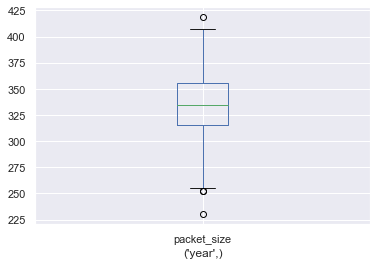

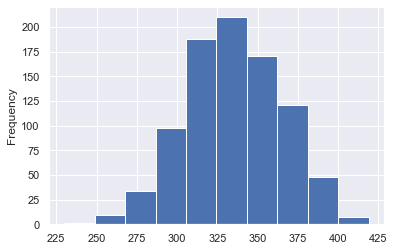

,packet_size,phonemes,words,sentence
68684,230,"(axr, h#)","(year,)",She had your dark suit in greasy wash water al...
70808,252,"(axr, h#)","(year,)",She had your dark suit in greasy wash water al...
29169,252,"(axr, h#)","(year,)",She had your dark suit in greasy wash water al...
68091,255,"(axr, h#)","(year,)",She had your dark suit in greasy wash water al...
80251,257,"(ih, axr, h#)","(year,)",She had your dark suit in greasy wash water al...
81537,261,"(ih, axr, h#)","(year,)",She had your dark suit in greasy wash water al...
12719,262,"(axr, h#)","(year,)",She had your dark suit in greasy wash water al...
75417,263,"(axr, h#)","(year,)",She had your dark suit in greasy wash water al...
73007,265,"(r, h#)","(year,)",She had your dark suit in greasy wash water al...
46664,267,"(y, ih, axr)","(year,)",She had your dark suit in greasy wash water al...


,packet_size,phonemes,words,sentence
60044,419,"(ih, axr)","(year,)",She had your dark suit in greasy wash water al...
3673,407,"(ih, er, h#)","(year,)",She had your dark suit in greasy wash water al...
22280,406,"(ih, er)","(year,)",She had your dark suit in greasy wash water al...
921,403,"(iy, axr)","(year,)",She had your dark suit in greasy wash water al...
21718,402,"(y, ih)","(year,)",She had your dark suit in greasy wash water al...
36480,401,"(axr, h#)","(year,)",She had your dark suit in greasy wash water al...
63846,401,"(y, ih, er)","(year,)",She had your dark suit in greasy wash water al...
40474,400,"(ih, axr)","(year,)",She had your dark suit in greasy wash water al...
64491,399,"(y, ih)","(year,)",She had your dark suit in greasy wash water al...
20819,399,"(ih, er)","(year,)",She had your dark suit in greasy wash water al...




Unique values: 120 	Unique phonemes: 47
Current label:		 ('greasy',)
Total values: 667
Lower outsiders: 8
Upper outsiders: 0



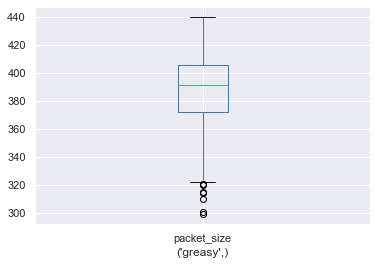

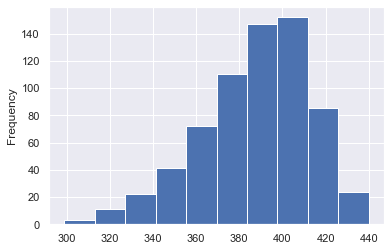

,packet_size,phonemes,words,sentence
22662,299,"(gcl, g, r, iy)","(greasy,)",She had your dark suit in greasy wash water al...
76323,301,"(gcl, g, r, iy)","(greasy,)",She had your dark suit in greasy wash water al...
35938,310,"(gcl, g, r, iy)","(greasy,)",She had your dark suit in greasy wash water al...
70072,314,"(gcl, g, r)","(greasy,)",She had your dark suit in greasy wash water al...
47772,315,"(gcl, g, r)","(greasy,)",She had your dark suit in greasy wash water al...
57306,320,"(gcl, g, r)","(greasy,)",She had your dark suit in greasy wash water al...
66183,321,"(gcl, g, r, iy, s)","(greasy,)",She had your dark suit in greasy wash water al...
30746,321,"(gcl, g, r, iy)","(greasy,)",She had your dark suit in greasy wash water al...
77244,322,"(gcl, g, r, iy)","(greasy,)",She had your dark suit in greasy wash water al...
48815,322,"(iy, pau)","(greasy,)",She had your dark suit in greasy wash water al...


,packet_size,phonemes,words,sentence
16119,440,"(r, iy, s)","(greasy,)",She had your dark suit in greasy wash water al...
40851,438,"(r, iy, z, iy)","(greasy,)",She had your dark suit in greasy wash water al...
39348,438,"(r, iy, s)","(greasy,)",She had your dark suit in greasy wash water al...
85383,437,"(r, iy, s)","(greasy,)",She had your dark suit in greasy wash water al...
47613,436,"(r, iy, s)","(greasy,)",She had your dark suit in greasy wash water al...
55303,435,"(r, iy, s)","(greasy,)",She had your dark suit in greasy wash water al...
28101,434,"(r, iy, s)","(greasy,)",She had your dark suit in greasy wash water al...
30411,434,"(iy, s)","(greasy,)",She had your dark suit in greasy wash water al...
4452,433,"(iy, s)","(greasy,)",She had your dark suit in greasy wash water al...
55659,431,"(r, iy, s)","(greasy,)",She had your dark suit in greasy wash water al...




Unique values: 110 	Unique phonemes: 41
Current label:		 ('she', 'had')
Total values: 459
Lower outsiders: 2
Upper outsiders: 1



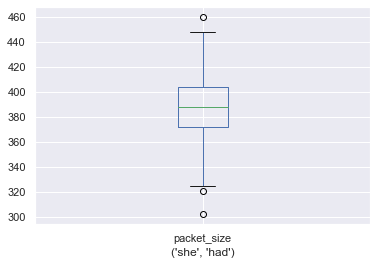

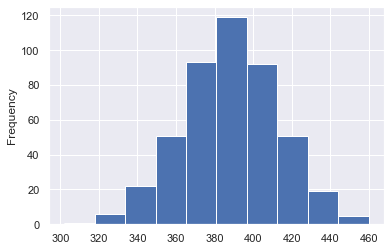

,packet_size,phonemes,words,sentence
13892,302,"(iy, ae)","(she, had)",She had your dark suit in greasy wash water al...
37012,321,"(iy, hv)","(she, had)",She had your dark suit in greasy wash water al...
19027,325,"(iy, hv, ae)","(she, had)",She had your dark suit in greasy wash water al...
59791,327,"(iy, hv, ae)","(she, had)",She had your dark suit in greasy wash water al...
65636,328,"(iy, hv, ae)","(she, had)",She had your dark suit in greasy wash water al...
18270,329,"(iy, hh, ae)","(she, had)",She had your dark suit in greasy wash water al...
12484,333,"(iy, hv, eh)","(she, had)",She had your dark suit in greasy wash water al...
66691,335,"(iy, hv)","(she, had)",She had your dark suit in greasy wash water al...
65977,336,"(iy, hv, ae)","(she, had)",She had your dark suit in greasy wash water al...
7413,337,"(iy, hv, ae)","(she, had)",She had your dark suit in greasy wash water al...


,packet_size,phonemes,words,sentence
23967,460,"(iy, hv, ae)","(she, had)",She had your dark suit in greasy wash water al...
18649,448,"(iy, hv, eh)","(she, had)",She had your dark suit in greasy wash water al...
50469,447,"(iy, hv, ae)","(she, had)",She had your dark suit in greasy wash water al...
63832,445,"(iy, hv, ae)","(she, had)",She had your dark suit in greasy wash water al...
62844,445,"(iy, hv, ae)","(she, had)",She had your dark suit in greasy wash water al...
46227,442,"(iy, hv, eh)","(she, had)",She had your dark suit in greasy wash water al...
22844,439,"(iy, hv, ae)","(she, had)",She had your dark suit in greasy wash water al...
23400,439,"(iy, hv, ae)","(she, had)",She had your dark suit in greasy wash water al...
45599,438,"(iy, hv, eh)","(she, had)",She had your dark suit in greasy wash water al...
83133,438,"(sh, iy, hv, ae)","(she, had)",She had your dark suit in greasy wash water al...


In [18]:
label_data['words'] = label_data['words'].astype('object')

#change this array for analysis on more values
interesting_words = [("",), ("that",), ("year",), ("greasy",), ("she", "had")]

for word in interesting_words:
    graph_data = label_data.loc[label_data.words == word]
    #graph_data = graph_data.copy() #.loc was somehow acting up and not copying properly
    print("Unique values:", len(pd.unique(graph_data['packet_size'])), "\tUnique phonemes:", len(pd.unique(graph_data['phonemes'])))
    get_distribution_info(graph_data, word)
    print('\n')

label_data['phonemes'] = label_data['phonemes'].astype('category')

We can see, that the distribution is still all over the place, but more concise than for phonemes, which is kinda surprising. But the problem here is that for longer words we have multiple packet sizes that corespond to said word.

### Feature engineering

Our current analysises so far have only taken into account packet_size alone. Now we will foccus on surrounding packet sizes so we can deduce much more information about our packet sizes and their correspondence to phonemes / words.  
So let's look at data once again:

In [19]:
data

,file,speaker,sentence,packet_size,phonemes,words
0,DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,227,"(h#,)","(,)"
1,DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,380,"(h#, sh, ix)","(she,)"
2,DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,407,"(ix, hv, eh)","(she, had)"
3,DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,350,"(eh, dcl, jh)","(had, your)"
4,DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,281,"(jh, ih, dcl, d, ah)","(had, your, dark)"
...,...,...,...,...,...,...
86492,DR8-MTCS0-SX82.CSV,DR8-MTCS0,Good service should be rewarded by big tips.,268,"(ay, bcl, b, ih)","(by, big)"
86493,DR8-MTCS0-SX82.CSV,DR8-MTCS0,Good service should be rewarded by big tips.,253,"(ih, gcl)","(big,)"
86494,DR8-MTCS0-SX82.CSV,DR8-MTCS0,Good service should be rewarded by big tips.,315,"(gcl, t, ih)","(big, tips)"
86495,DR8-MTCS0-SX82.CSV,DR8-MTCS0,Good service should be rewarded by big tips.,279,"(ih, pcl, p)","(tips,)"


We will modify our file parsing function to add previous and next packet size to each record.

In [20]:
def file_parser_with_prev_next(path):
    file = open(path, 'r')
    lines = file.readlines()
    
    file_name = [path.split('/')[-1]]
    sentence = ""
    file_data = []
    
    has_value = False
    previous = 0
    
    for line in lines:
        line = line.strip()
        
        # if there are only 2 informations on line and second is h#, then ignore
        # strip line, split primarly on ; secondary on ,
        if (line.startswith('#')):
            if (not sentence):
                sentence = line[len('# Sentence: "'): len(line) - 1]
            continue
        
        line = line.split(';')
        
        if (len(line) == 1):
            #lines containing only their packet size and nothing else, they should be added
            #TODO
            line += [""]
            line += [""]
            #continue
        
        if (len(line) == 2):
            #this tries to remove most of the silence at the start of the recording
            #potentionally harmfull as we shouldn't clean test data this way (we will be reading labels)
            #if (line[1] == 'h#'):
            #    continue
            line += [""]
        
        line[1] = tuple(line[1].split(','))
        line[2] = tuple(list(map(lambda a: a.strip('"'), line[2].split(','))))
        
        if (has_value):
            file_data[-1][4] = line[0]
           
        # file_type and sentence contain duplicate informations, but are kept for readability
        line = file_name + [file_name[0][0:9]] + [sentence] + [previous] + [0] + line
        #adding previous as feature
        previous = line[5]
        file_data += [line]
        
        #adding next frame as feature
        has_value = True
        
        

    return pd.DataFrame(file_data, columns=['file', 'speaker', 'sentence', 'previous_packet', 'next_packet','packet_size', 'phonemes', 'words'])

def load_files_with_prev_next(directory):
    filelist = os.listdir(directory)
    #read them into pandas
    df_list = [file_parser_with_prev_next(directory+file) for file in filelist]
    #concatenate them together
    return pd.concat(df_list, ignore_index=True)

In [21]:
def convert_types(data_frame):
    data_frame['packet_size'] = pd.to_numeric(data_frame['packet_size'])
    data_frame['previous_packet'] = pd.to_numeric(data_frame['previous_packet'])
    data_frame['next_packet'] = pd.to_numeric(data_frame['next_packet'])

    data_frame['file'] = data_frame['file'].astype('category')
    data_frame['sentence'] = data_frame['sentence'].astype('category')
    data_frame['speaker'] = data_frame['speaker'].astype('category')

First we will be trying to explore Skype data set as the aproach, that we will be trying first requires smaller packet sizes (we need to be able to distinguish the word boundaries for our feature columns).

Now we will try to comeup with with new features for our dataset.

The new features we will be considering for our dataset are:
- previous packet_size
- next packet_size
- bigram of previous and current
- bigram of next and current
- trigram of previous and current

In [22]:
whatsapp_data = load_files_with_prev_next("./../data/whatsapp_train_data/")
convert_types(whatsapp_data)
whatsapp_data

,file,speaker,sentence,previous_packet,next_packet,packet_size,phonemes,words
0,DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,0,380,227,"(h#,)","(,)"
1,DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,227,407,380,"(h#, sh, ix)","(she,)"
2,DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,380,350,407,"(ix, hv, eh)","(she, had)"
3,DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,407,281,350,"(eh, dcl, jh)","(had, your)"
4,DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,350,327,281,"(jh, ih, dcl, d, ah)","(had, your, dark)"
...,...,...,...,...,...,...,...,...
86492,DR8-MTCS0-SX82.CSV,DR8-MTCS0,Good service should be rewarded by big tips.,286,253,268,"(ay, bcl, b, ih)","(by, big)"
86493,DR8-MTCS0-SX82.CSV,DR8-MTCS0,Good service should be rewarded by big tips.,268,315,253,"(ih, gcl)","(big,)"
86494,DR8-MTCS0-SX82.CSV,DR8-MTCS0,Good service should be rewarded by big tips.,253,279,315,"(gcl, t, ih)","(big, tips)"
86495,DR8-MTCS0-SX82.CSV,DR8-MTCS0,Good service should be rewarded by big tips.,315,392,279,"(ih, pcl, p)","(tips,)"


We will also be considering bigrams of current and previous / next and trigram of (previous, current, next) packet sizes.

In [23]:
def add_surrounding(data_frame):
    data_frame['prev_curr'] = list(zip(data_frame.previous_packet, data_frame.packet_size))
    data_frame['next_curr'] = list(zip(data_frame.next_packet, data_frame.packet_size))
    data_frame['packet_surrounding'] = list(zip(data_frame.previous_packet, data_frame.packet_size, data_frame.next_packet))
    
    #data_frame['prev_curr'] = data_frame['prev_curr'].astype('category')
    #data_frame['next_curr'] = data_frame['next_curr'].astype('category')
    #data_frame['packet_surrounding'] = data_frame['packet_surrounding'].astype('category')

add_surrounding(whatsapp_data)
whatsapp_data.dtypes

file                  category
speaker               category
sentence              category
previous_packet          int64
next_packet              int64
packet_size              int64
phonemes                object
words                   object
prev_curr               object
next_curr               object
packet_surrounding      object
dtype: object

In [24]:
whatsapp_data = whatsapp_data[['file', 'speaker', 'sentence', 'previous_packet', 'next_packet','packet_size', 'prev_curr', 'next_curr', 'packet_surrounding', 'phonemes', 'words']]
whatsapp_data

,file,speaker,sentence,previous_packet,next_packet,packet_size,prev_curr,next_curr,packet_surrounding,phonemes,words
0,DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,0,380,227,"(0, 227)","(380, 227)","(0, 227, 380)","(h#,)","(,)"
1,DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,227,407,380,"(227, 380)","(407, 380)","(227, 380, 407)","(h#, sh, ix)","(she,)"
2,DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,380,350,407,"(380, 407)","(350, 407)","(380, 407, 350)","(ix, hv, eh)","(she, had)"
3,DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,407,281,350,"(407, 350)","(281, 350)","(407, 350, 281)","(eh, dcl, jh)","(had, your)"
4,DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,350,327,281,"(350, 281)","(327, 281)","(350, 281, 327)","(jh, ih, dcl, d, ah)","(had, your, dark)"
...,...,...,...,...,...,...,...,...,...,...,...
86492,DR8-MTCS0-SX82.CSV,DR8-MTCS0,Good service should be rewarded by big tips.,286,253,268,"(286, 268)","(253, 268)","(286, 268, 253)","(ay, bcl, b, ih)","(by, big)"
86493,DR8-MTCS0-SX82.CSV,DR8-MTCS0,Good service should be rewarded by big tips.,268,315,253,"(268, 253)","(315, 253)","(268, 253, 315)","(ih, gcl)","(big,)"
86494,DR8-MTCS0-SX82.CSV,DR8-MTCS0,Good service should be rewarded by big tips.,253,279,315,"(253, 315)","(279, 315)","(253, 315, 279)","(gcl, t, ih)","(big, tips)"
86495,DR8-MTCS0-SX82.CSV,DR8-MTCS0,Good service should be rewarded by big tips.,315,392,279,"(315, 279)","(392, 279)","(315, 279, 392)","(ih, pcl, p)","(tips,)"


### More exploratory analysis

In [25]:
len(pd.unique(whatsapp_data['packet_surrounding']))

83958

In [26]:
pack_surr_freq = whatsapp_data[['packet_surrounding']].value_counts()
pack_surr_freq

packet_surrounding
(0, 271, 348)         4
(0, 283, 375)         4
(0, 265, 407)         4
(354, 306, 0)         4
(0, 253, 387)         4
                     ..
(362, 344, 350)       1
(362, 344, 354)       1
(362, 345, 266)       1
(362, 345, 301)       1
(0, 195, 312)         1
Length: 83958, dtype: int64

In [27]:
# compute counts of (number of apperances, how many times it's there)
np.asarray(np.unique(pack_surr_freq.array.to_numpy(), return_counts=True)).T

array([[    1, 81650],
       [    2,  2103],
       [    3,   179],
       [    4,    26]], dtype=int64)

Okay, this is really promising, almost all of our trigrams of packet sizes are unique, that means we could make a clasificator with high accuracy (but this also is a problem in a way, because we won't be able to generalise that easily). 97% of our data is unique with regards to trigrams of phoneme sizes.

But let's try to kick that into overdrive and look at pairs of (trigram, phoneme). 

In [28]:
trigram_freq = whatsapp_data[['packet_surrounding', 'phonemes']].value_counts()
trigram_freq = trigram_freq.copy(deep=True)
trigram_freq

packet_surrounding  phonemes          
(0, 257, 396)       (h#, sh)              4
(0, 251, 391)       (h#, sh)              3
(0, 238, 330)       (h#,)                 3
(0, 239, 393)       (h#, q)               2
(330, 313, 0)       (h#,)                 2
                                         ..
(362, 341, 227)     (iy, tcl)             1
(362, 341, 257)     (pcl, p, axr, pau)    1
(362, 341, 299)     (bcl, b, z, bcl)      1
(362, 341, 341)     (eh, l, ax)           1
(0, 195, 312)       (h#,)                 1
Length: 86353, dtype: int64

In [29]:
np.asarray(np.unique(trigram_freq.array.to_numpy(), return_counts=True)).T

array([[    1, 86213],
       [    2,   137],
       [    3,     2],
       [    4,     1]], dtype=int64)

Okay, but this is still worrysome. Even thought we've achieved higher granurality there are still trigrams, that correspond to multiple phoneme (128265 unique `trigrams` vs 538460 unique pairs of `(trigram, phoneme)`.

In [30]:
trigram_freq = whatsapp_data[['packet_surrounding', 'words']].value_counts()
trigram_freq = trigram_freq.copy(deep=True)
trigram_freq

packet_surrounding  words             
(0, 257, 396)       (she,)                4
(0, 238, 330)       (,)                   3
(312, 283, 0)       (,)                   2
(301, 315, 0)       (,)                   2
(331, 297, 0)       (,)                   2
                                         ..
(362, 340, 400)     (dispensing,)         1
(362, 340, 404)     (my, instructions)    1
(362, 341, 227)     (me, to)              1
(362, 341, 257)     (snapper,)            1
(0, 195, 312)       (,)                   1
Length: 86353, dtype: int64

In [31]:
np.asarray(np.unique(trigram_freq.array.to_numpy(), return_counts=True)).T

array([[    1, 86212],
       [    2,   139],
       [    3,     1],
       [    4,     1]], dtype=int64)

And now we even have 99% of unique values. This is extraordinary because for almost every datapoint we have a unique label which means we could easily learn some kind of clasificator on this.

So let's do a bit more of exploratory analysis with these new features:

In [32]:
phoneme_stat = whatsapp_data.loc[:, ('packet_size', 'packet_surrounding', 'file', 'speaker', 'phonemes', 'words', 'sentence')]
phoneme_stat

,packet_size,packet_surrounding,file,speaker,phonemes,words,sentence
0,227,"(0, 227, 380)",DR1-FCJF0-SA1.CSV,DR1-FCJF0,"(h#,)","(,)",She had your dark suit in greasy wash water al...
1,380,"(227, 380, 407)",DR1-FCJF0-SA1.CSV,DR1-FCJF0,"(h#, sh, ix)","(she,)",She had your dark suit in greasy wash water al...
2,407,"(380, 407, 350)",DR1-FCJF0-SA1.CSV,DR1-FCJF0,"(ix, hv, eh)","(she, had)",She had your dark suit in greasy wash water al...
3,350,"(407, 350, 281)",DR1-FCJF0-SA1.CSV,DR1-FCJF0,"(eh, dcl, jh)","(had, your)",She had your dark suit in greasy wash water al...
4,281,"(350, 281, 327)",DR1-FCJF0-SA1.CSV,DR1-FCJF0,"(jh, ih, dcl, d, ah)","(had, your, dark)",She had your dark suit in greasy wash water al...
...,...,...,...,...,...,...,...
86492,268,"(286, 268, 253)",DR8-MTCS0-SX82.CSV,DR8-MTCS0,"(ay, bcl, b, ih)","(by, big)",Good service should be rewarded by big tips.
86493,253,"(268, 253, 315)",DR8-MTCS0-SX82.CSV,DR8-MTCS0,"(ih, gcl)","(big,)",Good service should be rewarded by big tips.
86494,315,"(253, 315, 279)",DR8-MTCS0-SX82.CSV,DR8-MTCS0,"(gcl, t, ih)","(big, tips)",Good service should be rewarded by big tips.
86495,279,"(315, 279, 392)",DR8-MTCS0-SX82.CSV,DR8-MTCS0,"(ih, pcl, p)","(tips,)",Good service should be rewarded by big tips.


In [33]:
def analyse_phoneme_trigrams(trigram):
    concrete_phoneme = phoneme_stat[phoneme_stat.packet_surrounding == trigram]
    print("Unique values:", len(pd.unique(concrete_phoneme['phonemes'])))
    temp = concrete_phoneme.groupby(by=['phonemes', 'packet_surrounding'])['phonemes'].count()
    print("Total values: ",sum(temp.values))
    display(temp.sort_values(ascending=False))

    temp1 = concrete_phoneme.groupby(by=['phonemes', 'packet_surrounding', 'speaker'])['phonemes'].count()
    print("\nTotal values: ",sum(temp1.values))
    display(temp1.sort_values(ascending=False))
    print("\n")
    
interesting_trigrams = [(0, 257, 396), (0, 238, 330), (312, 283, 0), (331, 297, 0)]
for trigram in interesting_trigrams:
    #analyse_phoneme_trigrams(trigram)
    display(phoneme_stat[phoneme_stat['packet_surrounding'] == trigram])

,packet_size,packet_surrounding,file,speaker,phonemes,words,sentence
4254,257,"(0, 257, 396)",DR1-MMGG0-SA1.CSV,DR1-MMGG0,"(h#, sh)","(she,)",She had your dark suit in greasy wash water al...
14527,257,"(0, 257, 396)",DR2-MJEB0-SA1.CSV,DR2-MJEB0,"(h#, sh)","(she,)",She had your dark suit in greasy wash water al...
31735,257,"(0, 257, 396)",DR3-MRBC0-SA1.CSV,DR3-MRBC0,"(h#, sh)","(she,)",She had your dark suit in greasy wash water al...
54688,257,"(0, 257, 396)",DR5-MEWM0-SX178.CSV,DR5-MEWM0,"(h#, sh)","(she,)",She encouraged her children to make their own ...


,packet_size,packet_surrounding,file,speaker,phonemes,words,sentence
38963,238,"(0, 238, 330)",DR4-MDCD0-SA2.CSV,DR4-MDCD0,"(h#,)","(,)",Don't ask me to carry an oily rag like that.
47377,238,"(0, 238, 330)",DR4-MTQC0-SA2.CSV,DR4-MTQC0,"(h#,)","(,)",Don't ask me to carry an oily rag like that.
64309,238,"(0, 238, 330)",DR6-FTAJ0-SX69.CSV,DR6-FTAJ0,"(h#,)","(,)",Eat your raisins outdoors on the porch steps.


,packet_size,packet_surrounding,file,speaker,phonemes,words,sentence
38041,283,"(312, 283, 0)",DR4-MARW0-SI1276.CSV,DR4-MARW0,"(k, h#)","(task,)",Land-based radar would help with this task.
64723,283,"(312, 283, 0)",DR6-MBMA1-SA2.CSV,DR6-MBMA1,"(h#,)","(,)",Don't ask me to carry an oily rag like that.
75048,283,"(312, 283, 0)",DR7-MDLR1-SA2.CSV,DR7-MDLR1,"(h#,)","(,)",Don't ask me to carry an oily rag like that.


,packet_size,packet_surrounding,file,speaker,phonemes,words,sentence
42989,297,"(331, 297, 0)",DR4-MKAM0-SI1316.CSV,DR4-MKAM0,"(h#,)","(,)",Space probes have yielded little information.
60929,297,"(331, 297, 0)",DR5-MVLO0-SX247.CSV,DR5-MVLO0,"(h#,)","(,)",The cigarettes in the clay ashtray overflowed ...


We will now try something different: we will consider tuple `(phonemes, words)` as our label:

In [34]:
bilabel = whatsapp_data.loc[:, ('packet_size', 'packet_surrounding', 'file', 'speaker', 'sentence', 'phonemes', 'words')]
bilabel['phoneme_word'] = tuple(zip(whatsapp_data.phonemes, whatsapp_data.words))
bilabel

,packet_size,packet_surrounding,file,speaker,sentence,phonemes,words,phoneme_word
0,227,"(0, 227, 380)",DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,"(h#,)","(,)","((h#,), (,))"
1,380,"(227, 380, 407)",DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,"(h#, sh, ix)","(she,)","((h#, sh, ix), (she,))"
2,407,"(380, 407, 350)",DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,"(ix, hv, eh)","(she, had)","((ix, hv, eh), (she, had))"
3,350,"(407, 350, 281)",DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,"(eh, dcl, jh)","(had, your)","((eh, dcl, jh), (had, your))"
4,281,"(350, 281, 327)",DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,"(jh, ih, dcl, d, ah)","(had, your, dark)","((jh, ih, dcl, d, ah), (had, your, dark))"
...,...,...,...,...,...,...,...,...
86492,268,"(286, 268, 253)",DR8-MTCS0-SX82.CSV,DR8-MTCS0,Good service should be rewarded by big tips.,"(ay, bcl, b, ih)","(by, big)","((ay, bcl, b, ih), (by, big))"
86493,253,"(268, 253, 315)",DR8-MTCS0-SX82.CSV,DR8-MTCS0,Good service should be rewarded by big tips.,"(ih, gcl)","(big,)","((ih, gcl), (big,))"
86494,315,"(253, 315, 279)",DR8-MTCS0-SX82.CSV,DR8-MTCS0,Good service should be rewarded by big tips.,"(gcl, t, ih)","(big, tips)","((gcl, t, ih), (big, tips))"
86495,279,"(315, 279, 392)",DR8-MTCS0-SX82.CSV,DR8-MTCS0,Good service should be rewarded by big tips.,"(ih, pcl, p)","(tips,)","((ih, pcl, p), (tips,))"


In [35]:
len(pd.unique(bilabel['phoneme_word']))

48692

Now this is interesting, we can see, that in our dataset we have 48692 (skype had 87741) unique pairs of (phonemes, words) (original statistics are: xxxx unique n-grams of phonemes and xxxx unique n-grams of words).

In [36]:
bilabel_frequencies = bilabel['phoneme_word'].value_counts()
bilabel_frequencies.head(20)

((h#,), (,))                      3953
((h#, sh), (she,))                 444
((pau,), (,))                      337
((h#, d, ow), (don't,))            317
((s, ux), (suit,))                 297
((h#, dh), (the,))                 270
((sh, iy), (she,))                 267
((r, ae), (rag,))                  253
((ao, l, y), (all, year))          237
((ae, s), (ask,))                  221
((axr, h#), (year,))               218
((ae, tcl), (that,))               218
((kcl, dh, ae), (like, that))      168
((iy, hv, ae), (she, had))         165
((oy, l, iy), (oily,))             153
((s, iy, w), (greasy, wash))       147
((aa, r, kcl), (dark,))            139
((r, kcl, k, s), (dark, suit))     133
((aa, sh), (wash,))                132
((iy, r, ae), (oily, rag))         132
Name: phoneme_word, dtype: int64

These graphs only show values for `packet_size` and not the trigrams of values :(  
This statistics is mostly pointless and shows us whether we can "generalize" in some sort of way.

Unique trigram values: 3876 	Unique packet size values: 204
Current label:		 (('h#',), ('',))
Total values: 3953
Lower outsiders: 0
Upper outsiders: 2



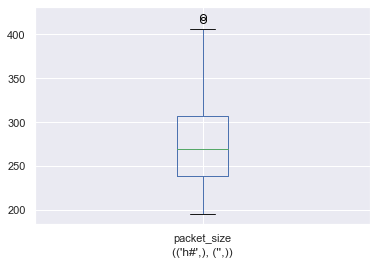

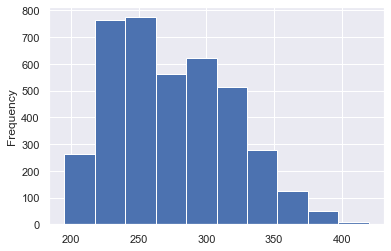

,packet_size,packet_surrounding,file,speaker,sentence,phonemes,words,phoneme_word
45465,195,"(0, 195, 312)",DR4-MRAB1-SI2108.CSV,DR4-MRAB1,Don't forget whiskey; it's such a big seller.,"(h#,)","(,)","((h#,), (,))"
77541,196,"(206, 196, 0)",DR7-MJJM0-SI827.CSV,DR7-MJJM0,Drug's chemical name: procaine penicillin.,"(h#,)","(,)","((h#,), (,))"
74673,197,"(0, 197, 310)",DR7-MDLM0-SA2.CSV,DR7-MDLM0,Don't ask me to carry an oily rag like that.,"(h#,)","(,)","((h#,), (,))"
77454,197,"(215, 197, 217)",DR7-MJJM0-SA1.CSV,DR7-MJJM0,She had your dark suit in greasy wash water al...,"(h#,)","(,)","((h#,), (,))"
21466,197,"(239, 197, 0)",DR3-FCMG0-SX162.CSV,DR3-FCMG0,Her auburn hair reminded him of autumn leaves.,"(h#,)","(,)","((h#,), (,))"
15407,198,"(262, 198, 0)",DR2-MJPM0-SX378.CSV,DR2-MJPM0,I just saw Jim near the new archeological museum.,"(h#,)","(,)","((h#,), (,))"
9169,198,"(229, 198, 0)",DR2-FKAA0-SI578.CSV,DR2-FKAA0,She can remove all knick-knacks within reach.,"(h#,)","(,)","((h#,), (,))"
34678,198,"(0, 198, 363)",DR3-MWDK0-SI806.CSV,DR3-MWDK0,You need answers to four important questions.,"(h#,)","(,)","((h#,), (,))"
21528,198,"(251, 198, 0)",DR3-FCMG0-SX432.CSV,DR3-FCMG0,"Coffee is grown on steep, jungle-like slopes i...","(h#,)","(,)","((h#,), (,))"
25326,199,"(288, 199, 0)",DR3-MAPV0-SA2.CSV,DR3-MAPV0,Don't ask me to carry an oily rag like that.,"(h#,)","(,)","((h#,), (,))"


,packet_size,packet_surrounding,file,speaker,sentence,phonemes,words,phoneme_word
23944,420,"(247, 420, 366)",DR3-FPAZ0-SX63.CSV,DR3-FPAZ0,Continental drift is a geological theory.,"(h#,)","(,)","((h#,), (,))"
2501,416,"(319, 416, 282)",DR1-FVMH0-SI836.CSV,DR1-FVMH0,No manufacturer has taken the initiative in po...,"(h#,)","(,)","((h#,), (,))"
4622,406,"(251, 406, 345)",DR1-MMRP0-SX54.CSV,DR1-MMRP0,The eastern coast is a place for pure pleasure...,"(h#,)","(,)","((h#,), (,))"
18542,401,"(278, 401, 317)",DR2-MRJH0-SX169.CSV,DR2-MRJH0,How would you evaluate this algebraic expression?,"(h#,)","(,)","((h#,), (,))"
69929,399,"(252, 399, 371)",DR7-FKDE0-SI1771.CSV,DR7-FKDE0,"A thick, crimson carpet muffled every footfall.","(h#,)","(,)","((h#,), (,))"
51381,399,"(274, 399, 356)",DR5-FPMY0-SI523.CSV,DR5-FPMY0,Under this law annual grants are given to syst...,"(h#,)","(,)","((h#,), (,))"
40904,398,"(314, 398, 345)",DR4-MJDC0-SI531.CSV,DR4-MJDC0,"He spoke briefly, sensibly, to the point and w...","(h#,)","(,)","((h#,), (,))"
7832,398,"(371, 398, 0)",DR2-FCYL0-SI1927.CSV,DR2-FCYL0,You do that or take you out a permit right now.,"(h#,)","(,)","((h#,), (,))"
53520,394,"(263, 394, 334)",DR5-MCLM0-SI2086.CSV,DR5-MCLM0,Absolution for his lie?,"(h#,)","(,)","((h#,), (,))"
67760,394,"(256, 394, 300)",DR6-MSMR0-SX145.CSV,DR6-MSMR0,Too much curiosity can get you into trouble.,"(h#,)","(,)","((h#,), (,))"




Unique trigram values: 337 	Unique packet size values: 136
Current label:		 (('pau',), ('',))
Total values: 337
Lower outsiders: 0
Upper outsiders: 0



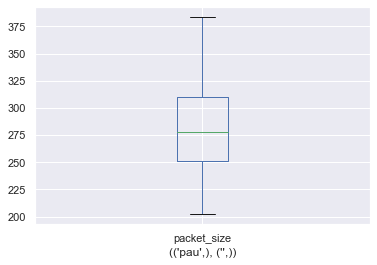

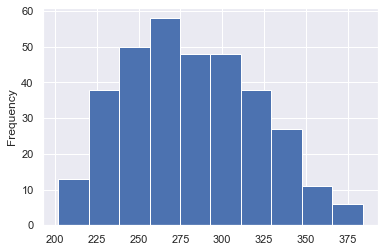

,packet_size,packet_surrounding,file,speaker,sentence,phonemes,words,phoneme_word
35437,202,"(229, 202, 293)",DR4-FBMJ0-SI815.CSV,DR4-FBMJ0,Push back up and repeat.,"(pau,)","(,)","((pau,), (,))"
84665,208,"(259, 208, 355)",DR8-MEJS0-SX340.CSV,DR8-MEJS0,Ducks have webbed feet and colorful feathers.,"(pau,)","(,)","((pau,), (,))"
10642,209,"(338, 209, 222)",DR2-FSCN0-SI705.CSV,DR2-FSCN0,"Ants carry the seeds, so better be sure that t...","(pau,)","(,)","((pau,), (,))"
21971,214,"(267, 214, 268)",DR3-FEME0-SI875.CSV,DR3-FEME0,Look for these features which may mean you can...,"(pau,)","(,)","((pau,), (,))"
86010,214,"(264, 214, 223)",DR8-MRLK0-SI843.CSV,DR8-MRLK0,"To begin with, what is an interior designer?","(pau,)","(,)","((pau,), (,))"
25199,215,"(255, 215, 327)",DR3-MAKR0-SI1982.CSV,DR3-MAKR0,"Two cars came over a crest, their chrome and g...","(pau,)","(,)","((pau,), (,))"
63320,215,"(228, 215, 354)",DR6-FPAD0-SI1976.CSV,DR6-FPAD0,"Wingman, stay clear, he prayed.","(pau,)","(,)","((pau,), (,))"
59053,216,"(209, 216, 325)",DR5-MRML0-SI1421.CSV,DR5-MRML0,"Though brief, it has a sharp dramatic edge and...","(pau,)","(,)","((pau,), (,))"
56402,216,"(285, 216, 342)",DR5-MJWG0-SI813.CSV,DR5-MJWG0,"Push-ups: push-ups are essential, but few have...","(pau,)","(,)","((pau,), (,))"
33058,219,"(226, 219, 370)",DR3-MRTJ0-SX232.CSV,DR3-MRTJ0,His failure to open the store by eight cost hi...,"(pau,)","(,)","((pau,), (,))"


,packet_size,packet_surrounding,file,speaker,sentence,phonemes,words,phoneme_word
54526,384,"(299, 384, 286)",DR5-MEGJ0-SX167.CSV,DR5-MEGJ0,Employee layoffs coincided with the company's ...,"(pau,)","(,)","((pau,), (,))"
36543,382,"(323, 382, 362)",DR4-FKDW0-SI1891.CSV,DR4-FKDW0,"His eyes were dark, fluid, fearful, and he gav...","(pau,)","(,)","((pau,), (,))"
50327,377,"(281, 377, 321)",DR5-FLJA0-SI1078.CSV,DR5-FLJA0,"The smell is sexual, but so powerfully so that...","(pau,)","(,)","((pau,), (,))"
54768,372,"(308, 372, 287)",DR5-MEWM0-SX88.CSV,DR5-MEWM0,Flying standby can be practical if you want to...,"(pau,)","(,)","((pau,), (,))"
82745,370,"(299, 370, 286)",DR8-FBCG1-SX352.CSV,DR8-FBCG1,"According to my interpretation of the problem,...","(pau,)","(,)","((pau,), (,))"
40913,368,"(400, 368, 401)",DR4-MJDC0-SI531.CSV,DR4-MJDC0,"He spoke briefly, sensibly, to the point and w...","(pau,)","(,)","((pau,), (,))"
36544,362,"(382, 362, 347)",DR4-FKDW0-SI1891.CSV,DR4-FKDW0,"His eyes were dark, fluid, fearful, and he gav...","(pau,)","(,)","((pau,), (,))"
49512,360,"(254, 360, 293)",DR5-FGDP0-SI988.CSV,DR5-FGDP0,"A kerosene shampoo seems a heroic treatment, b...","(pau,)","(,)","((pau,), (,))"
58056,360,"(387, 360, 375)",DR5-MPMB0-SX61.CSV,DR5-MPMB0,Chocolate and roses never fail as a romantic g...,"(pau,)","(,)","((pau,), (,))"
3505,359,"(373, 359, 320)",DR1-MJEB1-SI1467.CSV,DR1-MJEB1,The platform accelerometers must be slightly m...,"(pau,)","(,)","((pau,), (,))"




Unique trigram values: 315 	Unique packet size values: 115
Current label:		 (('h#', 'd', 'ow'), ("don't",))
Total values: 317
Lower outsiders: 0
Upper outsiders: 9



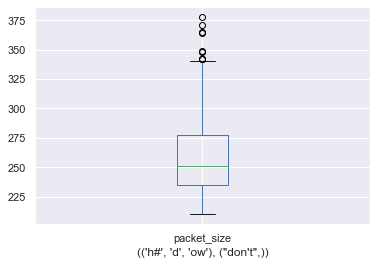

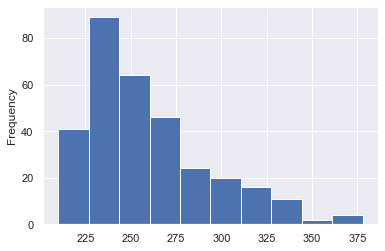

,packet_size,packet_surrounding,file,speaker,sentence,phonemes,words,phoneme_word
65995,210,"(0, 210, 371)",DR6-MKES0-SA2.CSV,DR6-MKES0,Don't ask me to carry an oily rag like that.,"(h#, d, ow)","(don't,)","((h#, d, ow), (don't,))"
46255,210,"(0, 210, 334)",DR4-MSFH0-SA2.CSV,DR4-MSFH0,Don't ask me to carry an oily rag like that.,"(h#, d, ow)","(don't,)","((h#, d, ow), (don't,))"
31354,210,"(0, 210, 360)",DR3-MMSM0-SA2.CSV,DR3-MMSM0,Don't ask me to carry an oily rag like that.,"(h#, d, ow)","(don't,)","((h#, d, ow), (don't,))"
27027,211,"(0, 211, 369)",DR3-MDJM0-SA2.CSV,DR3-MDJM0,Don't ask me to carry an oily rag like that.,"(h#, d, ow)","(don't,)","((h#, d, ow), (don't,))"
43711,212,"(0, 212, 300)",DR4-MLJH0-SA2.CSV,DR4-MLJH0,Don't ask me to carry an oily rag like that.,"(h#, d, ow)","(don't,)","((h#, d, ow), (don't,))"
24381,214,"(0, 214, 355)",DR3-FSKC0-SA2.CSV,DR3-FSKC0,Don't ask me to carry an oily rag like that.,"(h#, d, ow)","(don't,)","((h#, d, ow), (don't,))"
80776,215,"(0, 215, 405)",DR7-MTER0-SA2.CSV,DR7-MTER0,Don't ask me to carry an oily rag like that.,"(h#, d, ow)","(don't,)","((h#, d, ow), (don't,))"
45266,215,"(0, 215, 354)",DR4-MPRT0-SA2.CSV,DR4-MPRT0,Don't ask me to carry an oily rag like that.,"(h#, d, ow)","(don't,)","((h#, d, ow), (don't,))"
38203,215,"(0, 215, 372)",DR4-MBMA0-SA2.CSV,DR4-MBMA0,Don't ask me to carry an oily rag like that.,"(h#, d, ow)","(don't,)","((h#, d, ow), (don't,))"
13048,216,"(0, 216, 386)",DR2-MDPS0-SA2.CSV,DR2-MDPS0,Don't ask me to carry an oily rag like that.,"(h#, d, ow)","(don't,)","((h#, d, ow), (don't,))"


,packet_size,packet_surrounding,file,speaker,sentence,phonemes,words,phoneme_word
66890,378,"(241, 378, 383)",DR6-MRXB0-SA2.CSV,DR6-MRXB0,Don't ask me to carry an oily rag like that.,"(h#, d, ow)","(don't,)","((h#, d, ow), (don't,))"
62470,371,"(297, 371, 446)",DR6-FJDM2-SA2.CSV,DR6-FJDM2,Don't ask me to carry an oily rag like that.,"(h#, d, ow)","(don't,)","((h#, d, ow), (don't,))"
84216,365,"(214, 365, 353)",DR8-MBSB0-SA2.CSV,DR8-MBSB0,Don't ask me to carry an oily rag like that.,"(h#, d, ow)","(don't,)","((h#, d, ow), (don't,))"
25842,364,"(240, 364, 355)",DR3-MCDC0-SA2.CSV,DR3-MCDC0,Don't ask me to carry an oily rag like that.,"(h#, d, ow)","(don't,)","((h#, d, ow), (don't,))"
6136,349,"(236, 349, 406)",DR1-MTJS0-SA2.CSV,DR1-MTJS0,Don't ask me to carry an oily rag like that.,"(h#, d, ow)","(don't,)","((h#, d, ow), (don't,))"
31161,348,"(276, 348, 370)",DR3-MMJB1-SA2.CSV,DR3-MMJB1,Don't ask me to carry an oily rag like that.,"(h#, d, ow)","(don't,)","((h#, d, ow), (don't,))"
46053,342,"(234, 342, 310)",DR4-MRSP0-SA2.CSV,DR4-MRSP0,Don't ask me to carry an oily rag like that.,"(h#, d, ow)","(don't,)","((h#, d, ow), (don't,))"
9645,342,"(246, 342, 376)",DR2-FMJB0-SA2.CSV,DR2-FMJB0,Don't ask me to carry an oily rag like that.,"(h#, d, ow)","(don't,)","((h#, d, ow), (don't,))"
34273,342,"(242, 342, 394)",DR3-MTPP0-SA2.CSV,DR3-MTPP0,Don't ask me to carry an oily rag like that.,"(h#, d, ow)","(don't,)","((h#, d, ow), (don't,))"
36137,340,"(239, 340, 370)",DR4-FJWB1-SA2.CSV,DR4-FJWB1,Don't ask me to carry an oily rag like that.,"(h#, d, ow)","(don't,)","((h#, d, ow), (don't,))"




Unique trigram values: 420 	Unique packet size values: 112
Current label:		 (('h#', 'sh'), ('she',))
Total values: 444
Lower outsiders: 2
Upper outsiders: 39



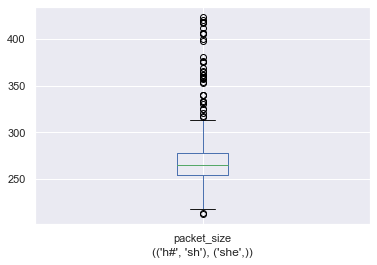

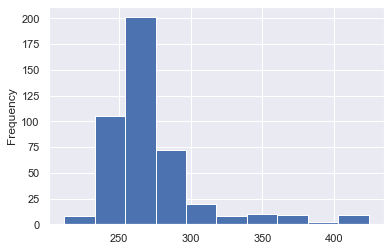

,packet_size,packet_surrounding,file,speaker,sentence,phonemes,words,phoneme_word
2763,212,"(0, 212, 388)",DR1-MDAC0-SA1.CSV,DR1-MDAC0,She had your dark suit in greasy wash water al...,"(h#, sh)","(she,)","((h#, sh), (she,))"
53797,214,"(0, 214, 404)",DR5-MDHL0-SA1.CSV,DR5-MDHL0,She had your dark suit in greasy wash water al...,"(h#, sh)","(she,)","((h#, sh), (she,))"
39694,218,"(0, 218, 399)",DR4-MFWK0-SA1.CSV,DR4-MFWK0,She had your dark suit in greasy wash water al...,"(h#, sh)","(she,)","((h#, sh), (she,))"
83496,224,"(0, 224, 400)",DR8-FMBG0-SA1.CSV,DR8-FMBG0,She had your dark suit in greasy wash water al...,"(h#, sh)","(she,)","((h#, sh), (she,))"
25638,230,"(0, 230, 383)",DR3-MCAL0-SA1.CSV,DR3-MCAL0,She had your dark suit in greasy wash water al...,"(h#, sh)","(she,)","((h#, sh), (she,))"
13522,230,"(0, 230, 385)",DR2-MEFG0-SA1.CSV,DR2-MEFG0,She had your dark suit in greasy wash water al...,"(h#, sh)","(she,)","((h#, sh), (she,))"
9067,231,"(0, 231, 393)",DR2-FKAA0-SA1.CSV,DR2-FKAA0,She had your dark suit in greasy wash water al...,"(h#, sh)","(she,)","((h#, sh), (she,))"
76559,233,"(0, 233, 399)",DR7-MHBS0-SI2205.CSV,DR7-MHBS0,"She saw me and sat down beside me, three feet ...","(h#, sh)","(she,)","((h#, sh), (she,))"
39875,234,"(0, 234, 360)",DR4-MGAG0-SA1.CSV,DR4-MGAG0,She had your dark suit in greasy wash water al...,"(h#, sh)","(she,)","((h#, sh), (she,))"
37010,234,"(0, 234, 402)",DR4-FLKM0-SA1.CSV,DR4-FLKM0,She had your dark suit in greasy wash water al...,"(h#, sh)","(she,)","((h#, sh), (she,))"


,packet_size,packet_surrounding,file,speaker,sentence,phonemes,words,phoneme_word
51895,424,"(238, 424, 347)",DR5-FSJG0-SA1.CSV,DR5-FSJG0,She had your dark suit in greasy wash water al...,"(h#, sh)","(she,)","((h#, sh), (she,))"
62213,420,"(261, 420, 373)",DR6-FHXS0-SA1.CSV,DR6-FHXS0,She had your dark suit in greasy wash water al...,"(h#, sh)","(she,)","((h#, sh), (she,))"
48866,418,"(240, 418, 368)",DR5-FDTD0-SI2191.CSV,DR5-FDTD0,She didn't even give me a chance to refuse.,"(h#, sh)","(she,)","((h#, sh), (she,))"
40454,418,"(243, 418, 407)",DR4-MGXP0-SA1.CSV,DR4-MGXP0,She had your dark suit in greasy wash water al...,"(h#, sh)","(she,)","((h#, sh), (she,))"
76678,417,"(243, 417, 385)",DR7-MHXL0-SA1.CSV,DR7-MHXL0,She had your dark suit in greasy wash water al...,"(h#, sh)","(she,)","((h#, sh), (she,))"
34255,412,"(224, 412, 351)",DR3-MTPP0-SA1.CSV,DR3-MTPP0,She had your dark suit in greasy wash water al...,"(h#, sh)","(she,)","((h#, sh), (she,))"
47348,407,"(211, 407, 368)",DR4-MTQC0-SA1.CSV,DR4-MTQC0,She had your dark suit in greasy wash water al...,"(h#, sh)","(she,)","((h#, sh), (she,))"
5317,406,"(250, 406, 415)",DR1-MRCG0-SA1.CSV,DR1-MRCG0,She had your dark suit in greasy wash water al...,"(h#, sh)","(she,)","((h#, sh), (she,))"
21699,405,"(226, 405, 390)",DR3-FDJH0-SA1.CSV,DR3-FDJH0,She had your dark suit in greasy wash water al...,"(h#, sh)","(she,)","((h#, sh), (she,))"
46225,400,"(263, 400, 345)",DR4-MSFH0-SA1.CSV,DR4-MSFH0,She had your dark suit in greasy wash water al...,"(h#, sh)","(she,)","((h#, sh), (she,))"




Unique trigram values: 46 	Unique packet size values: 40
Current label:		 (('',), ('',))
Total values: 46
Lower outsiders: 0
Upper outsiders: 0



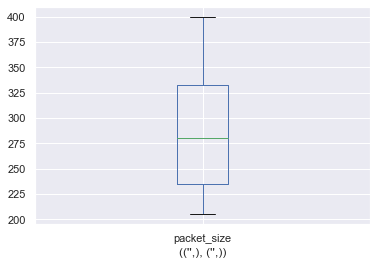

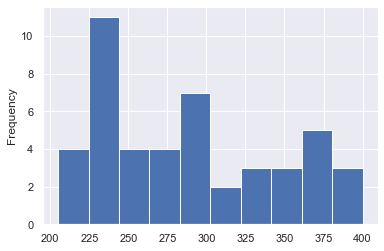

,packet_size,packet_surrounding,file,speaker,sentence,phonemes,words,phoneme_word
44528,205,"(0, 205, 341)",DR4-MMGC0-SA2.CSV,DR4-MMGC0,Don't ask me to carry an oily rag like that.,"(,)","(,)","((,), (,))"
34118,212,"(228, 212, 0)",DR3-MTPG0-SA2.CSV,DR3-MTPG0,Don't ask me to carry an oily rag like that.,"(,)","(,)","((,), (,))"
72300,215,"(235, 215, 0)",DR7-MAEO0-SX426.CSV,DR7-MAEO0,A moth zig-zagged along the path through Otto'...,"(,)","(,)","((,), (,))"
58765,224,"(0, 224, 252)",DR5-MRKM0-SX367.CSV,DR5-MRKM0,The surplus shoes were sold at a discount price.,"(,)","(,)","((,), (,))"
12248,227,"(0, 227, 357)",DR2-MDEM0-SA1.CSV,DR2-MDEM0,She had your dark suit in greasy wash water al...,"(,)","(,)","((,), (,))"
34117,228,"(268, 228, 212)",DR3-MTPG0-SA2.CSV,DR3-MTPG0,Don't ask me to carry an oily rag like that.,"(,)","(,)","((,), (,))"
58615,229,"(0, 229, 309)",DR5-MRKM0-SA2.CSV,DR5-MRKM0,Don't ask me to carry an oily rag like that.,"(,)","(,)","((,), (,))"
58698,233,"(0, 233, 241)",DR5-MRKM0-SI637.CSV,DR5-MRKM0,He enlisted a staff of loyal experts and of ma...,"(,)","(,)","((,), (,))"
6307,234,"(0, 234, 352)",DR1-MTJS0-SX382.CSV,DR1-MTJS0,George is paranoid about a future gas shortage.,"(,)","(,)","((,), (,))"
22366,234,"(0, 234, 327)",DR3-FGRW0-SX162.CSV,DR3-FGRW0,Her auburn hair reminded him of autumn leaves.,"(,)","(,)","((,), (,))"


,packet_size,packet_surrounding,file,speaker,sentence,phonemes,words,phoneme_word
7250,400,"(256, 400, 335)",DR2-FAJW0-SI1263.CSV,DR2-FAJW0,Both have excellent integration of their fisca...,"(,)","(,)","((,), (,))"
43307,395,"(325, 395, 361)",DR4-MLEL0-SA2.CSV,DR4-MLEL0,Don't ask me to carry an oily rag like that.,"(,)","(,)","((,), (,))"
43460,387,"(366, 387, 272)",DR4-MLEL0-SX436.CSV,DR4-MLEL0,Please sing just the club theme.,"(,)","(,)","((,), (,))"
43477,375,"(239, 375, 365)",DR4-MLEL0-SX76.CSV,DR4-MLEL0,Gently place Jim's foam sculpture in the box.,"(,)","(,)","((,), (,))"
43417,368,"(278, 368, 342)",DR4-MLEL0-SX256.CSV,DR4-MLEL0,The irate actor stomped away idiotically.,"(,)","(,)","((,), (,))"
43459,366,"(296, 366, 387)",DR4-MLEL0-SX436.CSV,DR4-MLEL0,Please sing just the club theme.,"(,)","(,)","((,), (,))"
6433,365,"(266, 365, 302)",DR1-MTPF0-SX245.CSV,DR1-MTPF0,Does Hindu ideology honor cows?,"(,)","(,)","((,), (,))"
6309,361,"(352, 361, 311)",DR1-MTJS0-SX382.CSV,DR1-MTJS0,George is paranoid about a future gas shortage.,"(,)","(,)","((,), (,))"
1591,358,"(239, 358, 294)",DR1-FSAH0-SI614.CSV,DR1-FSAH0,"This big, flexible voice with uncommon range h...","(,)","(,)","((,), (,))"
12249,357,"(227, 357, 354)",DR2-MDEM0-SA1.CSV,DR2-MDEM0,She had your dark suit in greasy wash water al...,"(,)","(,)","((,), (,))"


In [37]:
#change this array for analysis on more values
interesting_bilabels = [(("h#",), ("",)), (("pau",), ("",)), (('h#', 'd', 'ow'), ("don't",)), (('h#', 'sh'), ('she',)), (('',), ('',))]

for bila in interesting_bilabels:
    graph_data = bilabel.loc[bilabel.phoneme_word == bila]
    print("Unique trigram values:", len(pd.unique(graph_data['packet_surrounding'])), "\tUnique packet size values:", len(pd.unique(graph_data['packet_size'])))
    #graph_data = graph_data.copy() #.loc was somehow acting up and not copying properly
    get_distribution_info(graph_data, bila)
    print('\n')

Still the values for the phonemes are kinda "all over the place" but not that much as with analysis for only words / phonemes. But the all these analyses have a common downfall, majority of the samples overlap with their "packet_size". 

So let's try to look at analysis based on triphones (our distinguishing factor will be _words_).

Let's now try to group analysis for both packet surrouding and words.

In [47]:
trigram_freq = bilabel[['packet_surrounding', 'words']].value_counts()
#trigram_freq = bilabel[['packet_surrounding']].value_counts()
trigram_freq = trigram_freq.copy(deep=True)
trigram_freq

packet_surrounding  words             
(0, 257, 396)       (she,)                4
(0, 238, 330)       (,)                   3
(312, 283, 0)       (,)                   2
(301, 315, 0)       (,)                   2
(331, 297, 0)       (,)                   2
                                         ..
(362, 340, 400)     (dispensing,)         1
(362, 340, 404)     (my, instructions)    1
(362, 341, 227)     (me, to)              1
(362, 341, 257)     (snapper,)            1
(0, 195, 312)       (,)                   1
Length: 86353, dtype: int64

In [48]:
print("Sanity sum check:", sum(trigram_freq.values))
np.asarray(np.unique(trigram_freq.array.to_numpy(), return_counts=True)).T

Sanity sum check: 86497


array([[    1, 86212],
       [    2,   139],
       [    3,     1],
       [    4,     1]], dtype=int64)

Well we've achieved a huge granurality, which isn't a good thing. This says to me that with packet sizes that there will be inherently some lost information in translation. So the problem with this granurality is that we will hardly be able to generalise our model (as it seems, that multiple trigrams of packets sizes encode different `(phonemes, words)`.

We've achieved an awesome level of granularity as only 231 trigrams of packet sizes have repeating values.

In [40]:
def analyse_phoneme_trigrams(trigram):
    concrete_phoneme = bilabel[bilabel.packet_surrounding == trigram]
    print("Unique values:", len(pd.unique(concrete_phoneme['phoneme_word'])))
    temp = concrete_phoneme.groupby(by=['phoneme_word', 'packet_surrounding'])['phonemes'].count()
    print("Total values: ",sum(temp.values))
    display(temp.sort_values(ascending=False))

    temp1 = concrete_phoneme.groupby(by=['phoneme_word', 'packet_surrounding', 'speaker'])['phonemes'].count()
    print("\nTotal values: ",sum(temp1.values))
    display(temp1.sort_values(ascending=False))
    print("\n")
    
interesting_trigrams = [(0, 257, 396), (0, 238, 330), (0, 255, 394) , (0, 241, 375)]
for trigram in interesting_trigrams:
    #analyse_phoneme_trigrams(trigram)
    display(bilabel[bilabel['packet_surrounding'] == trigram])

,packet_size,packet_surrounding,file,speaker,sentence,phonemes,words,phoneme_word
4254,257,"(0, 257, 396)",DR1-MMGG0-SA1.CSV,DR1-MMGG0,She had your dark suit in greasy wash water al...,"(h#, sh)","(she,)","((h#, sh), (she,))"
14527,257,"(0, 257, 396)",DR2-MJEB0-SA1.CSV,DR2-MJEB0,She had your dark suit in greasy wash water al...,"(h#, sh)","(she,)","((h#, sh), (she,))"
31735,257,"(0, 257, 396)",DR3-MRBC0-SA1.CSV,DR3-MRBC0,She had your dark suit in greasy wash water al...,"(h#, sh)","(she,)","((h#, sh), (she,))"
54688,257,"(0, 257, 396)",DR5-MEWM0-SX178.CSV,DR5-MEWM0,She encouraged her children to make their own ...,"(h#, sh)","(she,)","((h#, sh), (she,))"


,packet_size,packet_surrounding,file,speaker,sentence,phonemes,words,phoneme_word
38963,238,"(0, 238, 330)",DR4-MDCD0-SA2.CSV,DR4-MDCD0,Don't ask me to carry an oily rag like that.,"(h#,)","(,)","((h#,), (,))"
47377,238,"(0, 238, 330)",DR4-MTQC0-SA2.CSV,DR4-MTQC0,Don't ask me to carry an oily rag like that.,"(h#,)","(,)","((h#,), (,))"
64309,238,"(0, 238, 330)",DR6-FTAJ0-SX69.CSV,DR6-FTAJ0,Eat your raisins outdoors on the porch steps.,"(h#,)","(,)","((h#,), (,))"


,packet_size,packet_surrounding,file,speaker,sentence,phonemes,words,phoneme_word
23710,255,"(0, 255, 394)",DR3-FNTB0-SX213.CSV,DR3-FNTB0,The news agency hired a great journalist.,"(h#, dh)","(the,)","((h#, dh), (the,))"
40620,255,"(0, 255, 394)",DR4-MGXP0-SX7.CSV,DR4-MGXP0,Nothing is as offensive as innocence.,"(h#,)","(,)","((h#,), (,))"
60908,255,"(0, 255, 394)",DR5-MVLO0-SX247.CSV,DR5-MVLO0,The cigarettes in the clay ashtray overflowed ...,"(h#, dh)","(the,)","((h#, dh), (the,))"


,packet_size,packet_surrounding,file,speaker,sentence,phonemes,words,phoneme_word
5968,241,"(0, 241, 375)",DR1-MRWS0-SA2.CSV,DR1-MRWS0,Don't ask me to carry an oily rag like that.,"(h#, d, ow)","(don't,)","((h#, d, ow), (don't,))"
24941,241,"(0, 241, 375)",DR3-MAKB0-SA2.CSV,DR3-MAKB0,Don't ask me to carry an oily rag like that.,"(h#, d, ow)","(don't,)","((h#, d, ow), (don't,))"


REPHRASE: _And it is as we feared, the trigram of packet sizes aren't that well defined and don't provide us with definitive answer to clasification and recognition._

Analysis -> go over all unique 3gram values and select those whose "unique phoneme word count is > 1"

In [41]:
"""output = []
for trigram in pd.unique(bilabel['packet_surrounding']):
    temp = bilabel[bilabel['packet_surrounding'] == trigram]
    if len(pd.unique(temp['phoneme_word'])) > 1:
        output += [trigram]
        
print(len(output))
"""
print("this takes too long to run :(")

this takes too long to run :(


### Models

So let's look at what we have come up with:

In [42]:
data

,file,speaker,sentence,packet_size,phonemes,words
0,DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,227,"(h#,)","(,)"
1,DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,380,"(h#, sh, ix)","(she,)"
2,DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,407,"(ix, hv, eh)","(she, had)"
3,DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,350,"(eh, dcl, jh)","(had, your)"
4,DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,281,"(jh, ih, dcl, d, ah)","(had, your, dark)"
...,...,...,...,...,...,...
86492,DR8-MTCS0-SX82.CSV,DR8-MTCS0,Good service should be rewarded by big tips.,268,"(ay, bcl, b, ih)","(by, big)"
86493,DR8-MTCS0-SX82.CSV,DR8-MTCS0,Good service should be rewarded by big tips.,253,"(ih, gcl)","(big,)"
86494,DR8-MTCS0-SX82.CSV,DR8-MTCS0,Good service should be rewarded by big tips.,315,"(gcl, t, ih)","(big, tips)"
86495,DR8-MTCS0-SX82.CSV,DR8-MTCS0,Good service should be rewarded by big tips.,279,"(ih, pcl, p)","(tips,)"
